In [2]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
  print(f'Running on a TPU w/{tp.num_accelerators()["TPU"]} cores')
except ValueError:
  raise BaseException('Error: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)

''

In [3]:
# Download ticker data for given stock
def format_data(ticker_str, *, pred_period, increase_percent, test_split, verbose=False, return_all=False):
  # Download the adjusted data
  ticker = yf.Ticker(ticker_str)
  data = ticker.history(period='max', auto_adjust=True).drop(['Dividends', 'Stock Splits'], axis=1)

  # Print some information about the data
  if verbose:
    print('\n', data.describe())
    print(data.head())
    print(data.tail())

  # Convert to numpy
  data = data.to_numpy()

  # Generate the samples and labels
  X = np.empty([len(data)-(pred_period+1), pred_period, 5])
  Y = np.empty([len(data)-(pred_period+1), 1], dtype='int8')

  for i in range(len(X)):
    X[i] = data[i:i+pred_period]

    open = data[i+pred_period+1][0]
    close = data[i+pred_period+1][3]

    if ((close-open)/(open+1e-8)) >= increase_percent:
      Y[i][0] = 1
    else:
      Y[i][0] = 0

  X = np.expand_dims(X, axis=3)

  # Seperate into train and test
  shuffle_indicies = np.random.permutation(X.shape[0])
  train_len = round((1-test_split)*len(shuffle_indicies))
  train_indicies = shuffle_indicies[:train_len]
  test_indicies = shuffle_indicies[train_len:]

  if return_all:
    return (X, Y), (X[train_indicies], Y[train_indicies]), (X[test_indicies], Y[test_indicies])
  else:
    return (X[train_indicies], Y[train_indicies]), (X[test_indicies], Y[test_indicies])

In [4]:
# Create and return convolutional model
def CNNModel1(pred_period, optimizer, loss, metrics, verbose=False):
  model = keras.Sequential()

  model.add(keras.Input(shape=(pred_period, 5, 1)))

  model.add(layers.Conv2D(32, (3, 2), activation='relu'))
  model.add(layers.MaxPool2D((2, 2)))

  model.add(layers.Conv2D(32, (3, 1), activation='relu'))
  model.add(layers.MaxPool2D((2, 2)))

  model.add(layers.Conv2D(64, (3, 1), activation='relu'))

  model.add(layers.Flatten())

  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(1, activation='sigmoid'))

  if verbose:
    model.summary()

  model.compile(optimizer=optimizer,
             loss=loss,
             metrics=metrics)

  return model

In [5]:
# Plot accuracy and validation accuracy
def plot_accuracy(history, epochs):
  x_points = [i for i in range(1, epochs+1)]

  fig, axs = plt.subplots(2, 1)

  axs[0].set_title('Accuracy')
  axs[0].plot(x_points, history.history['accuracy'], label='Accuracy')
  axs[0].plot(x_points, history.history['val_accuracy'], label='Validation Accuracy')
  axs[0].legend(loc='lower right')

  axs[1].set_title('Binary Accuracy')
  axs[1].plot(x_points, history.history['binary_accuracy'], label='Binary Accuracy')
  axs[1].plot(x_points, history.history['val_binary_accuracy'], label='Validation Binary Accuracy')
  axs[1].legend(loc='lower right')

  plt.subplots_adjust(hspace=0.4)

  plt.show()

In [6]:
def print_wrapper(msg, n=3, char='-'):
  print(char*n + msg + char*n)

In [9]:
# Parameters for training
PRED_PERIOD = 40
INCREASE_PERCENT = .02
TEST_SPLIT = .1

OPTIMIZER='adam'
LOSS = 'binary_crossentropy'
METRICS = ['accuracy', keras.metrics.BinaryAccuracy()]

EPOCHS = 20
BATCH_SIZE = None
VALIDATION_SPLIT = .1

In [10]:
# Nvidia model
def test_model(model_fn, tickers, unique_rounding=1):
  for ticker in tickers:
    # Print the title of the model
    print( '-'*10 + f'Testing CNNModel1 for {ticker}'+ '-'*10)
    # Retrieve the data
    (X, Y), (x_train, y_train), (x_test, y_test) = format_data(ticker,
                                                              pred_period=PRED_PERIOD,
                                                              increase_percent=INCREASE_PERCENT,
                                                              test_split=TEST_SPLIT,
                                                              return_all=True)
    # Count the amount of ones in the output
    count = 0
    for x in np.squeeze(Y, axis=1):
      if x == 1:
        count += 1
    print_wrapper(f'# of ones in Y: {count} | {count/len(Y)*100}%')

    # Create the model
    model = model_fn(PRED_PERIOD,
                    optimizer=OPTIMIZER,
                    loss=LOSS,
                    metrics=METRICS)

    # Train the model
    history = model.fit(x_train,
                        y_train,
                        epochs=EPOCHS,
                        batch_size=BATCH_SIZE,
                        validation_split=VALIDATION_SPLIT)

    # Plot the evolution of the accuracy
    plot_accuracy(history, EPOCHS)

    # Test the model on test data
    print('-'*3 + 'Test metrics' + '-'*3)
    model.evaluate(x_test, y_test)

    # Print all the different unique outputs of the model
    print('-'*3 + 'Unique outputs', '-'*3)
    uniques, counts = np.unique([round(x[0], unique_rounding) for x in model(X).numpy()], return_counts=True)

    for i in range(len(uniques)):
      if counts[i] > 1:
        print(uniques[i], counts[i])

----------Testing CNNModel1 for NVDA----------
---# of ones in Y: 1266 | 19.89940270355234%---
Epoch 1/5
162/162 [==============================] - 4s 6ms/step - loss: 1855482.3750 - accuracy: 0.6656 - binary_accuracy: 0.6835 - val_loss: 503338.7188 - val_accuracy: 0.7731 - val_binary_accuracy: 0.7731
Epoch 2/5
162/162 [==============================] - 1s 5ms/step - loss: 241347.0625 - accuracy: 0.6759 - binary_accuracy: 0.6759 - val_loss: 195445.5938 - val_accuracy: 0.7086 - val_binary_accuracy: 0.7086
Epoch 3/5
162/162 [==============================] - 1s 5ms/step - loss: 113631.7969 - accuracy: 0.6800 - binary_accuracy: 0.6800 - val_loss: 152191.0469 - val_accuracy: 0.4677 - val_binary_accuracy: 0.4677
Epoch 4/5
162/162 [==============================] - 1s 5ms/step - loss: 125538.8984 - accuracy: 0.6845 - binary_accuracy: 0.6845 - val_loss: 80651.6562 - val_accuracy: 0.6213 - val_binary_accuracy: 0.6213
Epoch 5/5
162/162 [==============================] - 1s 5ms/step - loss: 4846

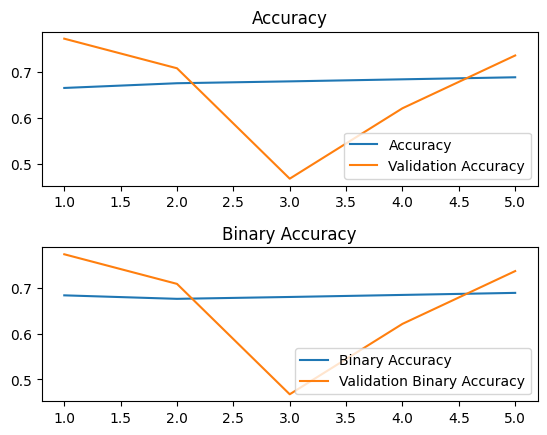

---Test metrics---
20/20 [==============================] - 0s 3ms/step - loss: 35138.9688 - accuracy: 0.7752 - binary_accuracy: 0.7752
---Unique outputs ---
0.0 5919
1.0 443
----------Testing CNNModel1 for INTC----------
---# of ones in Y: 1447 | 13.004403702705131%---
Epoch 1/5
282/282 [==============================] - 4s 8ms/step - loss: 116000.7422 - accuracy: 0.7571 - binary_accuracy: 0.7583 - val_loss: 16411.8750 - val_accuracy: 0.5958 - val_binary_accuracy: 0.5958
Epoch 2/5
282/282 [==============================] - 2s 8ms/step - loss: 5932.4771 - accuracy: 0.7574 - binary_accuracy: 0.7574 - val_loss: 2734.1582 - val_accuracy: 0.7864 - val_binary_accuracy: 0.7864
Epoch 3/5
282/282 [==============================] - 2s 6ms/step - loss: 1635.6193 - accuracy: 0.7638 - binary_accuracy: 0.7638 - val_loss: 1207.6390 - val_accuracy: 0.8423 - val_binary_accuracy: 0.8423
Epoch 4/5
282/282 [==============================] - 2s 7ms/step - loss: 850.2173 - accuracy: 0.7648 - binary_accurac

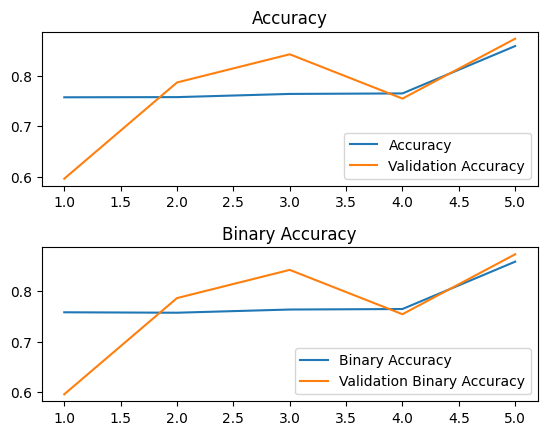

---Test metrics---
35/35 [==============================] - 0s 3ms/step - loss: 4.4488 - accuracy: 0.8850 - binary_accuracy: 0.8850
---Unique outputs ---
0.0 134
0.032 5
0.033 2
0.034 4
0.039 3
0.04 4
0.041 5
0.042 5
0.043 7
0.044 11
0.045 13
0.046 12
0.047 12
0.048 14
0.049 9
0.05 12
0.051 6
0.052 17
0.053 15
0.054 17
0.055 15
0.056 17
0.057 12
0.058 16
0.059 16
0.06 17
0.061 19
0.062 16
0.063 13
0.064 30
0.065 21
0.066 18
0.067 27
0.068 22
0.069 24
0.07 28
0.071 19
0.072 28
0.073 33
0.074 31
0.075 31
0.076 31
0.077 23
0.078 23
0.079 25
0.08 27
0.081 32
0.082 35
0.083 36
0.084 31
0.085 27
0.086 16
0.087 30
0.088 19
0.089 14
0.09 24
0.091 14
0.092 19
0.093 21
0.094 18
0.095 16
0.096 18
0.097 17
0.098 19
0.099 20
0.1 23
0.101 28
0.102 25
0.103 22
0.104 15
0.105 16
0.106 26
0.107 27
0.108 24
0.109 23
0.11 33
0.111 24
0.112 21
0.113 28
0.114 33
0.115 30
0.116 27
0.117 21
0.118 41
0.119 27
0.12 38
0.121 49
0.122 33
0.123 36
0.124 40
0.125 61
0.126 56
0.127 39
0.128 42
0.129 35
0.13 36
0.13

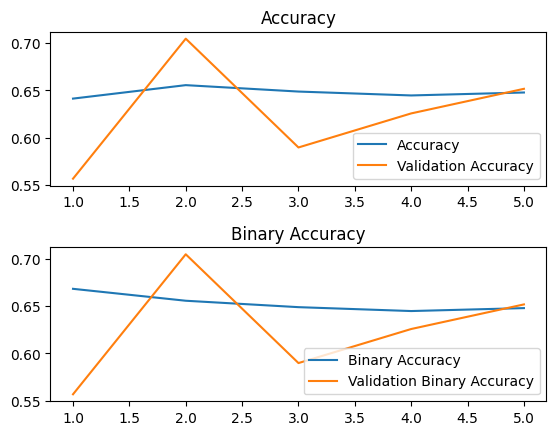

---Test metrics---
35/35 [==============================] - 0s 5ms/step - loss: 409.7688 - accuracy: 0.6685 - binary_accuracy: 0.6685
---Unique outputs ---
0.0 9072
0.001 22
0.002 9
0.003 6
0.004 4
0.005 4
0.006 7
0.007 3
0.008 4
0.009 2
0.01 5
0.011 3
0.012 3
0.014 3
0.016 2
0.017 2
0.019 2
0.026 2
0.037 2
0.055 2
0.056 2
0.063 2
0.248 2
0.543 2
0.6 2
0.863 2
0.942 2
0.944 2
0.978 2
0.986 2
0.988 2
0.991 2
0.993 2
0.994 2
0.996 3
0.997 6
0.998 6
0.999 13
1.0 1803
----------Testing CNNModel1 for NVDA----------
---# of ones in Y: 1266 | 19.89940270355234%---
Epoch 1/50
162/162 [==============================] - 2s 6ms/step - loss: 1677191.3750 - accuracy: 0.6685 - binary_accuracy: 0.6685 - val_loss: 332087.7812 - val_accuracy: 0.6562 - val_binary_accuracy: 0.6562
Epoch 2/50
162/162 [==============================] - 1s 6ms/step - loss: 196529.5625 - accuracy: 0.6742 - binary_accuracy: 0.6742 - val_loss: 141495.6719 - val_accuracy: 0.7452 - val_binary_accuracy: 0.7452
Epoch 3/50
162/162 

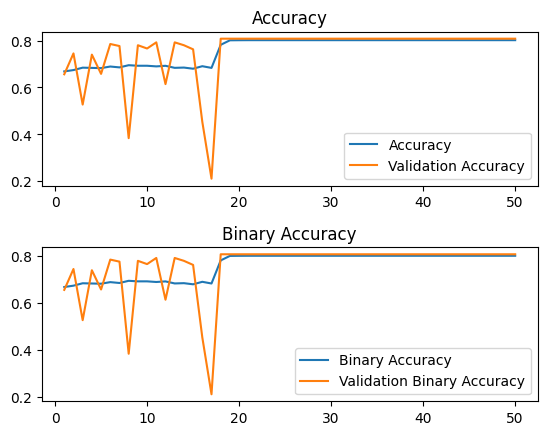

---Test metrics---
20/20 [==============================] - 0s 3ms/step - loss: 0.5088 - accuracy: 0.7940 - binary_accuracy: 0.7940
---Unique outputs ---
0.0 10
0.197 6349
1.0 3
----------Testing CNNModel1 for INTC----------
---# of ones in Y: 1447 | 13.004403702705131%---
Epoch 1/50
282/282 [==============================] - 3s 5ms/step - loss: 118308.9844 - accuracy: 0.7641 - binary_accuracy: 0.7661 - val_loss: 15226.7637 - val_accuracy: 0.8244 - val_binary_accuracy: 0.8244
Epoch 2/50
282/282 [==============================] - 1s 5ms/step - loss: 6580.1245 - accuracy: 0.7683 - binary_accuracy: 0.7683 - val_loss: 3731.0552 - val_accuracy: 0.7505 - val_binary_accuracy: 0.7505
Epoch 3/50
282/282 [==============================] - 2s 6ms/step - loss: 2776.3093 - accuracy: 0.7663 - binary_accuracy: 0.7663 - val_loss: 2148.5439 - val_accuracy: 0.7565 - val_binary_accuracy: 0.7565
Epoch 4/50
282/282 [==============================] - 2s 6ms/step - loss: 1613.5759 - accuracy: 0.7701 - binary

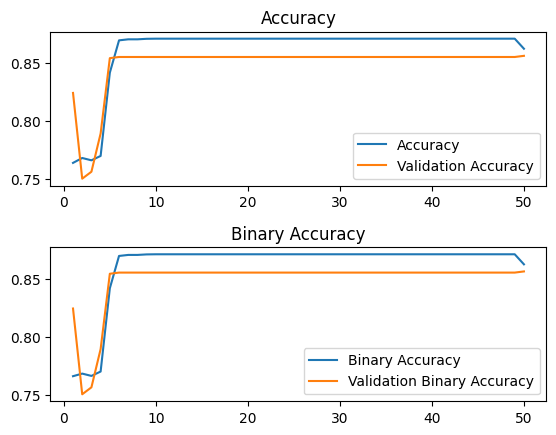

---Test metrics---
35/35 [==============================] - 0s 4ms/step - loss: 0.3795 - accuracy: 0.8742 - binary_accuracy: 0.8742
---Unique outputs ---
0.038 2
0.04 3
0.041 2
0.042 5
0.044 8
0.045 8
0.046 8
0.047 6
0.048 11
0.049 17
0.05 15
0.051 11
0.052 9
0.053 16
0.054 12
0.055 15
0.056 21
0.057 19
0.058 22
0.059 26
0.06 24
0.061 32
0.062 41
0.063 37
0.064 31
0.065 32
0.066 21
0.067 19
0.068 13
0.069 18
0.07 29
0.071 29
0.072 41
0.073 30
0.074 39
0.075 29
0.076 38
0.077 41
0.078 37
0.079 34
0.08 23
0.081 28
0.082 27
0.083 26
0.084 38
0.085 40
0.086 42
0.087 42
0.088 21
0.089 28
0.09 20
0.091 11
0.092 18
0.093 20
0.094 19
0.095 16
0.096 21
0.097 37
0.098 25
0.099 31
0.1 42
0.101 61
0.102 35
0.103 33
0.104 18
0.105 19
0.106 13
0.107 20
0.108 16
0.109 20
0.11 33
0.111 32
0.112 29
0.113 31
0.114 39
0.115 26
0.116 23
0.117 52
0.118 30
0.119 24
0.12 27
0.121 29
0.122 32
0.123 33
0.124 33
0.125 46
0.126 47
0.127 49
0.128 41
0.129 43
0.13 52
0.131 70
0.132 56
0.133 57
0.134 52
0.135 61
0.

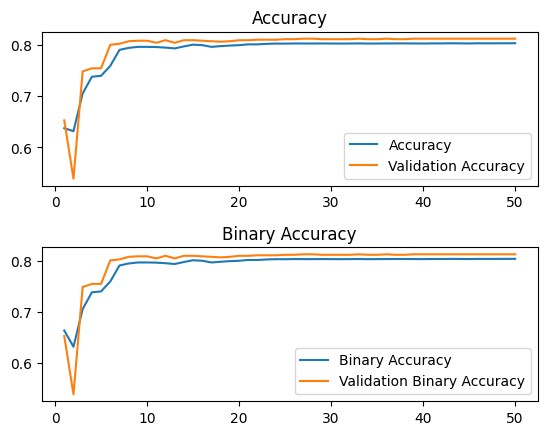

---Test metrics---
35/35 [==============================] - 0s 3ms/step - loss: 0.4572 - accuracy: 0.8203 - binary_accuracy: 0.8203
---Unique outputs ---
0.0 39
0.127 2
0.147 2
0.15 2
0.154 3
0.155 3
0.156 6
0.157 7
0.158 5
0.159 3
0.16 3
0.161 8
0.162 8
0.163 4
0.164 4
0.165 8
0.166 4
0.167 6
0.168 5
0.169 5
0.17 3
0.171 4
0.172 12
0.173 5
0.174 7
0.175 8
0.176 4
0.177 9
0.178 10
0.179 6
0.18 11
0.181 12
0.182 8
0.183 11
0.184 11
0.185 14
0.186 6
0.187 18
0.188 15
0.189 22
0.19 14
0.191 20
0.192 28
0.193 19
0.194 22
0.195 33
0.196 42
0.197 68
0.198 108
0.199 146
0.2 279
0.201 461
0.202 587
0.203 758
0.204 812
0.205 775
0.206 653
0.207 574
0.208 643
0.209 766
0.21 718
0.211 476
0.212 364
0.213 230
0.214 171
0.215 133
0.216 99
0.217 69
0.218 71
0.219 45
0.22 33
0.221 35
0.222 19
0.223 16
0.224 14
0.225 10
0.226 17
0.227 21
0.228 16
0.229 9
0.23 8
0.231 18
0.232 23
0.233 10
0.234 10
0.235 11
0.236 17
0.237 24
0.238 19
0.239 29
0.24 18
0.241 15
0.242 12
0.243 11
0.244 7
0.245 11
0.246 6
0

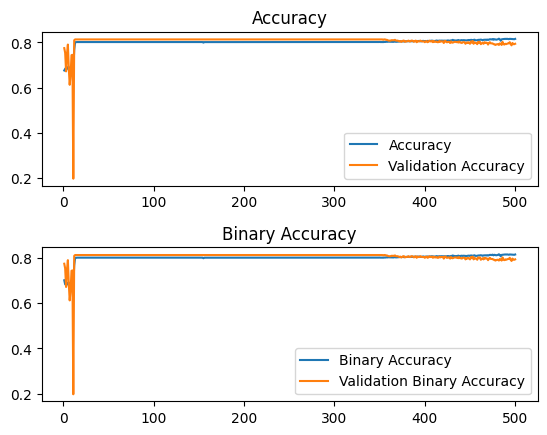

---Test metrics---
20/20 [==============================] - 0s 3ms/step - loss: 0.5623 - accuracy: 0.7783 - binary_accuracy: 0.7783
---Unique outputs ---
0.0 11
0.001 9
0.002 3
0.003 2
0.004 2
0.005 5
0.006 7
0.007 2
0.008 8
0.009 3
0.01 5
0.011 5
0.012 5
0.013 3
0.014 2
0.016 2
0.017 2
0.018 2
0.019 5
0.02 10
0.021 4
0.022 6
0.023 6
0.024 3
0.025 5
0.026 2
0.027 4
0.028 5
0.029 2
0.03 5
0.031 5
0.032 3
0.033 3
0.035 4
0.036 6
0.037 2
0.038 3
0.039 5
0.04 7
0.041 3
0.042 5
0.043 6
0.044 6
0.045 3
0.046 6
0.047 7
0.048 7
0.049 5
0.05 4
0.051 9
0.052 5
0.053 5
0.054 7
0.055 10
0.056 8
0.057 7
0.058 15
0.059 7
0.06 7
0.061 9
0.062 6
0.063 9
0.064 4
0.065 5
0.066 5
0.067 4
0.068 11
0.069 8
0.07 6
0.071 9
0.072 3
0.073 9
0.074 5
0.075 10
0.076 12
0.077 4
0.078 4
0.079 8
0.08 4
0.081 8
0.082 8
0.083 6
0.084 8
0.085 15
0.086 10
0.087 8
0.088 6
0.089 13
0.09 4
0.091 9
0.092 11
0.093 8
0.094 9
0.095 10
0.096 10
0.097 8
0.098 5
0.099 7
0.1 10
0.101 7
0.102 9
0.103 8
0.104 7
0.105 13
0.106 16
0.1

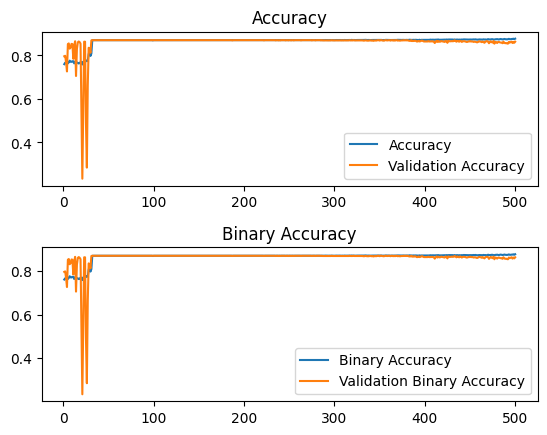

---Test metrics---
35/35 [==============================] - 0s 3ms/step - loss: 0.4185 - accuracy: 0.8616 - binary_accuracy: 0.8616
---Unique outputs ---
0.0 420
0.001 40
0.002 25
0.003 15
0.004 16
0.005 14
0.006 13
0.007 8
0.008 8
0.009 16
0.01 11
0.011 16
0.012 15
0.013 15
0.014 14
0.015 22
0.016 19
0.017 28
0.018 23
0.019 34
0.02 40
0.021 48
0.022 33
0.023 51
0.024 64
0.025 51
0.026 57
0.027 76
0.028 62
0.029 86
0.03 75
0.031 79
0.032 76
0.033 71
0.034 73
0.035 78
0.036 81
0.037 75
0.038 64
0.039 74
0.04 79
0.041 71
0.042 75
0.043 82
0.044 76
0.045 79
0.046 78
0.047 73
0.048 81
0.049 67
0.05 78
0.051 63
0.052 70
0.053 55
0.054 69
0.055 63
0.056 71
0.057 72
0.058 69
0.059 68
0.06 70
0.061 58
0.062 61
0.063 61
0.064 48
0.065 55
0.066 52
0.067 55
0.068 68
0.069 46
0.07 44
0.071 54
0.072 68
0.073 74
0.074 64
0.075 50
0.076 50
0.077 56
0.078 48
0.079 54
0.08 48
0.081 57
0.082 53
0.083 44
0.084 59
0.085 46
0.086 47
0.087 45
0.088 49
0.089 50
0.09 37
0.091 52
0.092 59
0.093 50
0.094 51
0.0

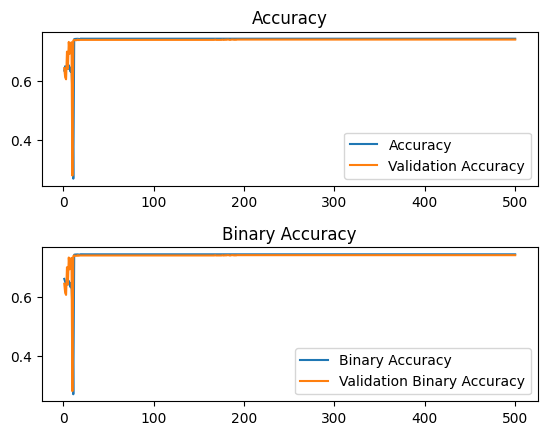

---Test metrics---
35/35 [==============================] - 0s 3ms/step - loss: 2.3911 - accuracy: 0.7385 - binary_accuracy: 0.7385
---Unique outputs ---
0.0 32
0.243 11088
1.0 7


In [ ]:
# Test more epochs
test_epochs = [5, 50, 500]
for x in test_epochs:
  EPOCHS = x
  test_model(CNNModel1, ['NVDA', 'INTC', 'AMD'])

----------Testing CNNModel1 for NVDA----------
---# of ones in Y: 1272 | 19.899874843554443%---
Epoch 1/20
162/162 [==============================] - 6s 11ms/step - loss: 1140430.8750 - accuracy: 0.6745 - binary_accuracy: 0.6745 - val_loss: 363049.3750 - val_accuracy: 0.5955 - val_binary_accuracy: 0.5955
Epoch 2/20
162/162 [==============================] - 1s 8ms/step - loss: 333541.3750 - accuracy: 0.6732 - binary_accuracy: 0.6732 - val_loss: 246075.8906 - val_accuracy: 0.7292 - val_binary_accuracy: 0.7292
Epoch 3/20
162/162 [==============================] - 1s 6ms/step - loss: 175467.4219 - accuracy: 0.6815 - binary_accuracy: 0.6815 - val_loss: 195413.7969 - val_accuracy: 0.7882 - val_binary_accuracy: 0.7882
Epoch 4/20
162/162 [==============================] - 1s 5ms/step - loss: 104529.5156 - accuracy: 0.6853 - binary_accuracy: 0.6853 - val_loss: 73290.3672 - val_accuracy: 0.5590 - val_binary_accuracy: 0.5590
Epoch 5/20
162/162 [==============================] - 1s 5ms/step - los

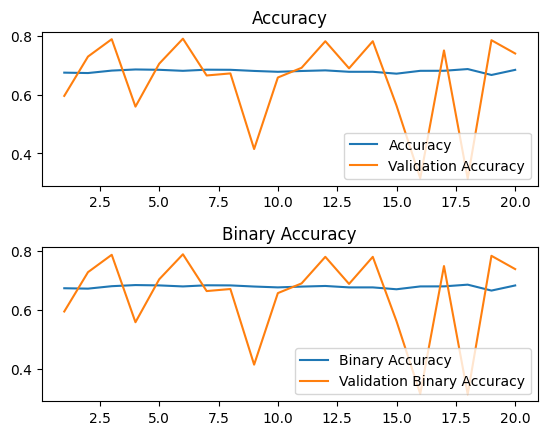

---Test metrics---
20/20 [==============================] - 1s 15ms/step - loss: 6421.8638 - accuracy: 0.7433 - binary_accuracy: 0.7433
---Unique outputs ---
0.0 5899
1.0 493
----------Testing CNNModel1 for INTC----------
---# of ones in Y: 1447 | 12.969436228376804%---
Epoch 1/20
283/283 [==============================] - 3s 7ms/step - loss: 67623.3828 - accuracy: 0.7620 - binary_accuracy: 0.7607 - val_loss: 39755.7227 - val_accuracy: 0.2975 - val_binary_accuracy: 0.2975
Epoch 2/20
283/283 [==============================] - 2s 7ms/step - loss: 14020.9863 - accuracy: 0.7689 - binary_accuracy: 0.7689 - val_loss: 10051.8916 - val_accuracy: 0.8617 - val_binary_accuracy: 0.8617
Epoch 3/20
283/283 [==============================] - 2s 6ms/step - loss: 5900.8628 - accuracy: 0.7635 - binary_accuracy: 0.7635 - val_loss: 7255.5684 - val_accuracy: 0.8597 - val_binary_accuracy: 0.8597
Epoch 4/20
283/283 [==============================] - 1s 5ms/step - loss: 3419.8228 - accuracy: 0.7672 - binary_a

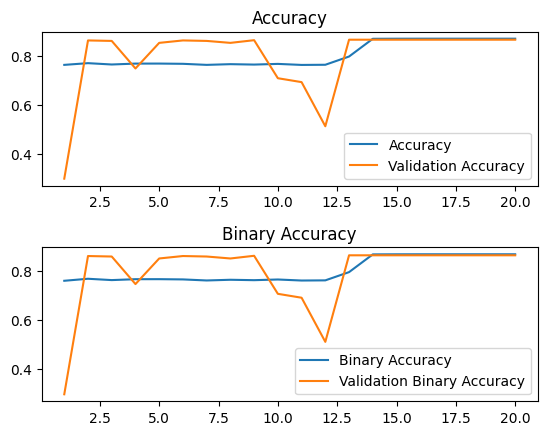

---Test metrics---
35/35 [==============================] - 0s 8ms/step - loss: 0.3527 - accuracy: 0.8871 - binary_accuracy: 0.8871
---Unique outputs ---
0.0 6
0.1 6981
0.2 4170
----------Testing CNNModel1 for AMD----------
---# of ones in Y: 2890 | 25.903020525230797%---
Epoch 1/20
283/283 [==============================] - 3s 5ms/step - loss: 34128.7305 - accuracy: 0.6436 - binary_accuracy: 0.6704 - val_loss: 6693.3076 - val_accuracy: 0.5552 - val_binary_accuracy: 0.5552
Epoch 2/20
283/283 [==============================] - 1s 5ms/step - loss: 4297.4307 - accuracy: 0.6469 - binary_accuracy: 0.6469 - val_loss: 2335.2812 - val_accuracy: 0.5582 - val_binary_accuracy: 0.5582
Epoch 3/20
283/283 [==============================] - 1s 5ms/step - loss: 1377.7274 - accuracy: 0.6435 - binary_accuracy: 0.6435 - val_loss: 1356.6962 - val_accuracy: 0.4527 - val_binary_accuracy: 0.4527
Epoch 4/20
283/283 [==============================] - 1s 5ms/step - loss: 755.7032 - accuracy: 0.6392 - binary_acc

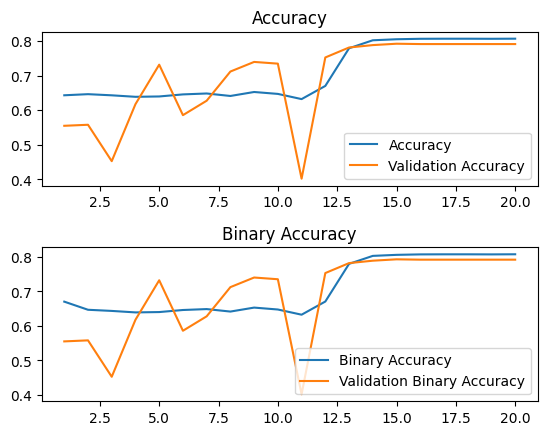

---Test metrics---
35/35 [==============================] - 0s 3ms/step - loss: 0.4781 - accuracy: 0.8091 - binary_accuracy: 0.8091
---Unique outputs ---
0.0 27
0.1 230
0.2 9405
0.3 712
0.4 23
0.5 3
0.8 3
0.9 747
1.0 5
----------Testing CNNModel1 for NVDA----------
---# of ones in Y: 1269 | 19.884048887496082%---
Epoch 1/20
162/162 [==============================] - 3s 10ms/step - loss: 1440869.3750 - accuracy: 0.6736 - binary_accuracy: 0.6977 - val_loss: 601977.1250 - val_accuracy: 0.4800 - val_binary_accuracy: 0.4800
Epoch 2/20
162/162 [==============================] - 1s 7ms/step - loss: 372256.5000 - accuracy: 0.6642 - binary_accuracy: 0.6642 - val_loss: 216198.3125 - val_accuracy: 0.6122 - val_binary_accuracy: 0.6122
Epoch 3/20
162/162 [==============================] - 1s 6ms/step - loss: 137069.7812 - accuracy: 0.6729 - binary_accuracy: 0.6729 - val_loss: 130143.7500 - val_accuracy: 0.6957 - val_binary_accuracy: 0.6957
Epoch 4/20
162/162 [==============================] - 1s 5m

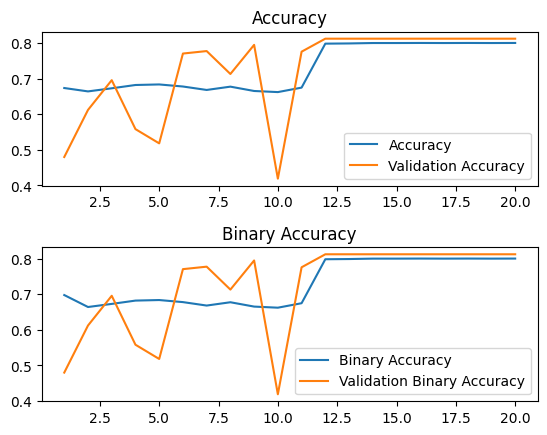

---Test metrics---
20/20 [==============================] - 0s 9ms/step - loss: 21.6794 - accuracy: 0.8009 - binary_accuracy: 0.8009
---Unique outputs ---
0.0 25
0.1 41
0.2 4769
0.3 1546
----------Testing CNNModel1 for INTC----------
---# of ones in Y: 1447 | 12.981071140217098%---
Epoch 1/20
283/283 [==============================] - 3s 7ms/step - loss: 30715.8145 - accuracy: 0.7635 - binary_accuracy: 0.7660 - val_loss: 8793.3955 - val_accuracy: 0.8456 - val_binary_accuracy: 0.8456
Epoch 2/20
283/283 [==============================] - 1s 5ms/step - loss: 3772.2827 - accuracy: 0.7712 - binary_accuracy: 0.7712 - val_loss: 2336.0977 - val_accuracy: 0.6245 - val_binary_accuracy: 0.6245
Epoch 3/20
283/283 [==============================] - 1s 5ms/step - loss: 1729.7620 - accuracy: 0.7675 - binary_accuracy: 0.7675 - val_loss: 2098.4626 - val_accuracy: 0.8596 - val_binary_accuracy: 0.8596
Epoch 4/20
283/283 [==============================] - 2s 7ms/step - loss: 1288.7937 - accuracy: 0.7697 -

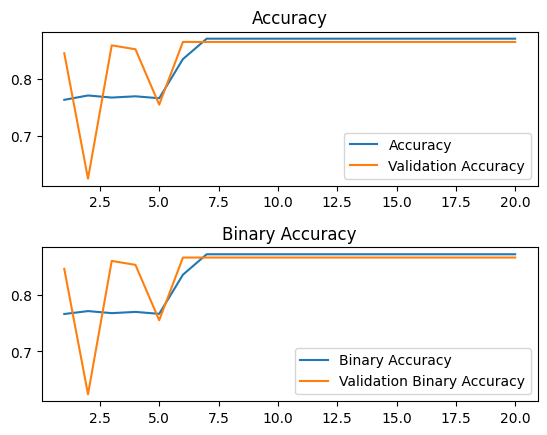

---Test metrics---
35/35 [==============================] - 0s 6ms/step - loss: 0.3898 - accuracy: 0.8655 - binary_accuracy: 0.8655
---Unique outputs ---
0.0 12
0.1 7276
0.2 3859
----------Testing CNNModel1 for AMD----------
---# of ones in Y: 2880 | 25.83654795012111%---
Epoch 1/20
283/283 [==============================] - 4s 6ms/step - loss: 29432.0449 - accuracy: 0.6485 - binary_accuracy: 0.6724 - val_loss: 9497.5088 - val_accuracy: 0.5697 - val_binary_accuracy: 0.5697
Epoch 2/20
283/283 [==============================] - 1s 5ms/step - loss: 4797.8076 - accuracy: 0.6514 - binary_accuracy: 0.6514 - val_loss: 2519.1079 - val_accuracy: 0.6125 - val_binary_accuracy: 0.6125
Epoch 3/20
283/283 [==============================] - 1s 5ms/step - loss: 1703.6859 - accuracy: 0.6405 - binary_accuracy: 0.6405 - val_loss: 1155.6431 - val_accuracy: 0.5827 - val_binary_accuracy: 0.5827
Epoch 4/20
283/283 [==============================] - 1s 5ms/step - loss: 839.5681 - accuracy: 0.6473 - binary_acc

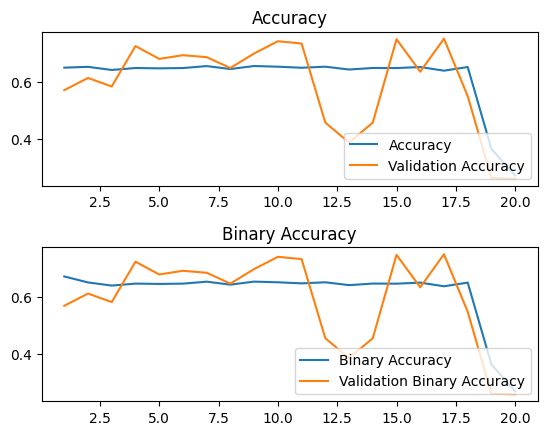

---Test metrics---
35/35 [==============================] - 0s 3ms/step - loss: 5.2340 - accuracy: 0.2726 - binary_accuracy: 0.2726
---Unique outputs ---
0.0 126
0.5 10992
1.0 26
----------Testing CNNModel1 for NVDA----------
---# of ones in Y: 1268 | 19.899560577526678%---
Epoch 1/20
162/162 [==============================] - 3s 8ms/step - loss: 1938234.0000 - accuracy: 0.6671 - binary_accuracy: 0.5970 - val_loss: 425033.9062 - val_accuracy: 0.7596 - val_binary_accuracy: 0.7596
Epoch 2/20
162/162 [==============================] - 1s 5ms/step - loss: 294180.8125 - accuracy: 0.6755 - binary_accuracy: 0.6755 - val_loss: 209208.3750 - val_accuracy: 0.6672 - val_binary_accuracy: 0.6672
Epoch 3/20
162/162 [==============================] - 1s 5ms/step - loss: 159659.9062 - accuracy: 0.6832 - binary_accuracy: 0.6832 - val_loss: 144179.0938 - val_accuracy: 0.5035 - val_binary_accuracy: 0.5035
Epoch 4/20
162/162 [==============================] - 1s 5ms/step - loss: 85899.9141 - accuracy: 0.6

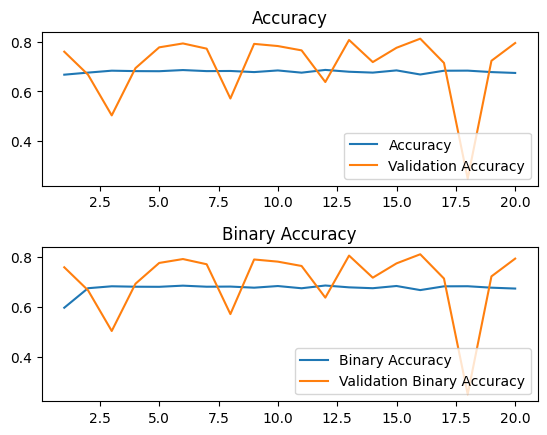

---Test metrics---
20/20 [==============================] - 0s 12ms/step - loss: 4419.6475 - accuracy: 0.7943 - binary_accuracy: 0.7943
---Unique outputs ---
0.0 6201
1.0 171
----------Testing CNNModel1 for INTC----------
---# of ones in Y: 1447 | 12.992726946215319%---
Epoch 1/20
282/282 [==============================] - 3s 7ms/step - loss: 41036.2734 - accuracy: 0.7673 - binary_accuracy: 0.7691 - val_loss: 13033.4990 - val_accuracy: 0.8644 - val_binary_accuracy: 0.8644
Epoch 2/20
282/282 [==============================] - 1s 5ms/step - loss: 5899.1665 - accuracy: 0.7652 - binary_accuracy: 0.7652 - val_loss: 3908.9917 - val_accuracy: 0.8235 - val_binary_accuracy: 0.8235
Epoch 3/20
282/282 [==============================] - 1s 5ms/step - loss: 2207.9351 - accuracy: 0.7615 - binary_accuracy: 0.7615 - val_loss: 1214.2776 - val_accuracy: 0.7856 - val_binary_accuracy: 0.7856
Epoch 4/20
282/282 [==============================] - 1s 5ms/step - loss: 987.7226 - accuracy: 0.7710 - binary_accu

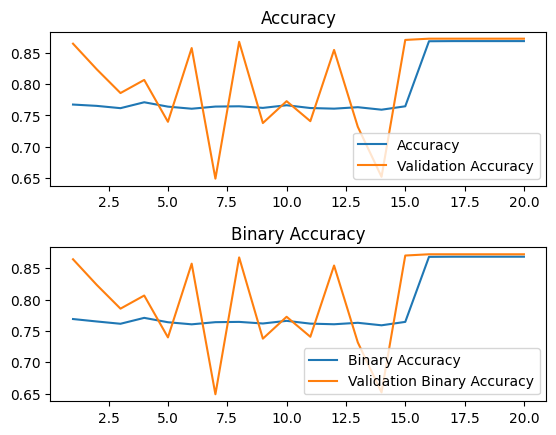

---Test metrics---
35/35 [==============================] - 0s 6ms/step - loss: 0.3658 - accuracy: 0.8806 - binary_accuracy: 0.8806
---Unique outputs ---
0.0 16
0.1 6965
0.2 4156
----------Testing CNNModel1 for AMD----------
---# of ones in Y: 2870 | 25.769956002514142%---
Epoch 1/20
282/282 [==============================] - 4s 7ms/step - loss: 29466.6074 - accuracy: 0.6425 - binary_accuracy: 0.6686 - val_loss: 8152.1250 - val_accuracy: 0.5683 - val_binary_accuracy: 0.5683
Epoch 2/20
282/282 [==============================] - 1s 5ms/step - loss: 5255.7832 - accuracy: 0.6431 - binary_accuracy: 0.6431 - val_loss: 2443.1438 - val_accuracy: 0.6830 - val_binary_accuracy: 0.6830
Epoch 3/20
282/282 [==============================] - 1s 5ms/step - loss: 2274.8943 - accuracy: 0.6426 - binary_accuracy: 0.6426 - val_loss: 1883.3313 - val_accuracy: 0.5384 - val_binary_accuracy: 0.5384
Epoch 4/20
282/282 [==============================] - 1s 5ms/step - loss: 1224.9487 - accuracy: 0.6466 - binary_a

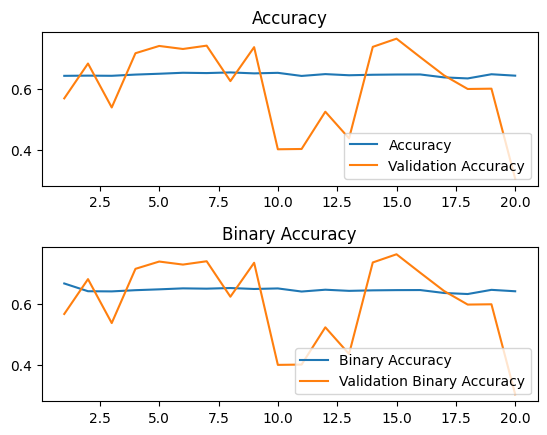

---Test metrics---
35/35 [==============================] - 0s 3ms/step - loss: 106.7001 - accuracy: 0.3339 - binary_accuracy: 0.3339
---Unique outputs ---
0.0 939
0.1 71
0.2 46
0.3 24
0.4 20
0.5 29
0.6 31
0.7 55
0.8 68
0.9 155
1.0 9699


In [ ]:
# Test different prediction period
pred_periods = [20, 30, 40]
for pred_period in pred_periods:
  PRED_PERIOD = pred_period
  test_model(CNNModel1, ['NVDA', 'INTC', 'AMD'])

----------Testing CNNModel1 for NVDA----------
---# of ones in Y: 2071 | 32.501569365976145%---
Epoch 1/20
162/162 [==============================] - 2s 6ms/step - loss: 2243156.2500 - accuracy: 0.5565 - binary_accuracy: 0.5170 - val_loss: 1140672.1250 - val_accuracy: 0.6672 - val_binary_accuracy: 0.6672
Epoch 2/20
162/162 [==============================] - 1s 5ms/step - loss: 649614.5625 - accuracy: 0.5555 - binary_accuracy: 0.5555 - val_loss: 456714.1875 - val_accuracy: 0.6080 - val_binary_accuracy: 0.6080
Epoch 3/20
162/162 [==============================] - 1s 5ms/step - loss: 306743.5625 - accuracy: 0.5722 - binary_accuracy: 0.5722 - val_loss: 246073.0312 - val_accuracy: 0.5488 - val_binary_accuracy: 0.5488
Epoch 4/20
162/162 [==============================] - 1s 5ms/step - loss: 165720.1562 - accuracy: 0.5747 - binary_accuracy: 0.5747 - val_loss: 149083.8438 - val_accuracy: 0.5958 - val_binary_accuracy: 0.5958
Epoch 5/20
162/162 [==============================] - 1s 5ms/step - lo

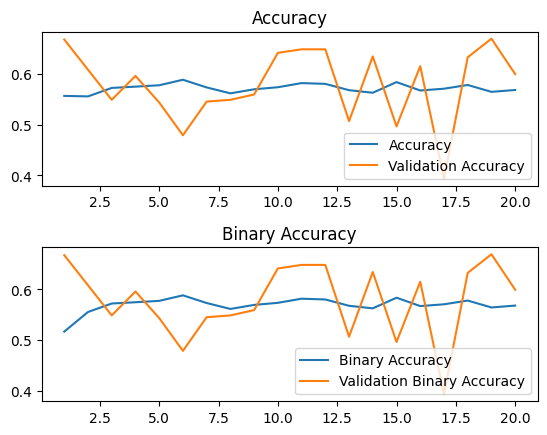

---Test metrics---
20/20 [==============================] - 0s 3ms/step - loss: 5753.1548 - accuracy: 0.6028 - binary_accuracy: 0.6028
---Unique outputs ---
0.0 5191
1.0 1180
----------Testing CNNModel1 for INTC----------
---# of ones in Y: 2895 | 25.994432971177154%---
Epoch 1/20
282/282 [==============================] - 3s 5ms/step - loss: 48968.5273 - accuracy: 0.5967 - binary_accuracy: 0.5971 - val_loss: 3643.5706 - val_accuracy: 0.6820 - val_binary_accuracy: 0.6820
Epoch 2/20
282/282 [==============================] - 1s 5ms/step - loss: 1537.0021 - accuracy: 0.5959 - binary_accuracy: 0.5959 - val_loss: 808.0009 - val_accuracy: 0.7198 - val_binary_accuracy: 0.7198
Epoch 3/20
282/282 [==============================] - 1s 5ms/step - loss: 698.2714 - accuracy: 0.5992 - binary_accuracy: 0.5992 - val_loss: 424.1844 - val_accuracy: 0.6421 - val_binary_accuracy: 0.6421
Epoch 4/20
282/282 [==============================] - 1s 5ms/step - loss: 493.2025 - accuracy: 0.5950 - binary_accuracy

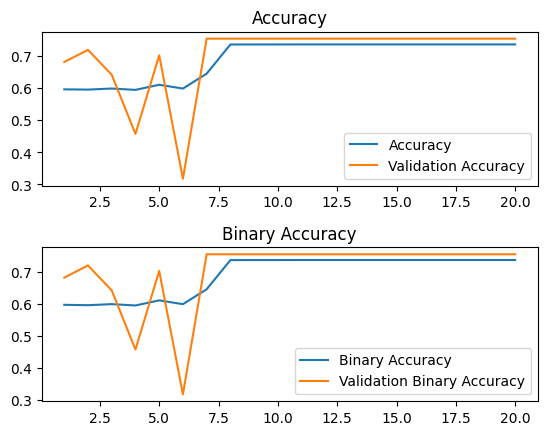

---Test metrics---
35/35 [==============================] - 0s 3ms/step - loss: 0.5593 - accuracy: 0.7531 - binary_accuracy: 0.7531
---Unique outputs ---
0.3 11137
----------Testing CNNModel1 for AMD----------
---# of ones in Y: 4104 | 36.85013917572057%---
Epoch 1/20
282/282 [==============================] - 3s 7ms/step - loss: 61626.8281 - accuracy: 0.5441 - binary_accuracy: 0.5671 - val_loss: 18911.5918 - val_accuracy: 0.6122 - val_binary_accuracy: 0.6122
Epoch 2/20
282/282 [==============================] - 2s 6ms/step - loss: 9766.1885 - accuracy: 0.5437 - binary_accuracy: 0.5437 - val_loss: 5067.7983 - val_accuracy: 0.5733 - val_binary_accuracy: 0.5733
Epoch 3/20
282/282 [==============================] - 1s 5ms/step - loss: 3218.1838 - accuracy: 0.5453 - binary_accuracy: 0.5453 - val_loss: 1946.6218 - val_accuracy: 0.5743 - val_binary_accuracy: 0.5743
Epoch 4/20
282/282 [==============================] - 1s 5ms/step - loss: 327.7369 - accuracy: 0.5337 - binary_accuracy: 0.5337 

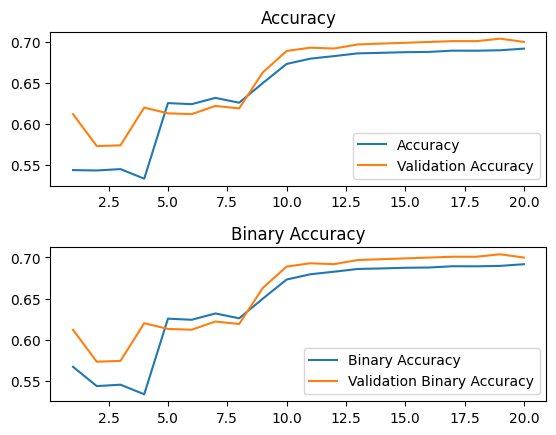

---Test metrics---
35/35 [==============================] - 0s 3ms/step - loss: 0.6447 - accuracy: 0.7217 - binary_accuracy: 0.7217
---Unique outputs ---
0.0 28
0.2 9
0.3 7207
0.4 2362
0.5 708
0.6 56
0.7 142
0.8 595
1.0 30
----------Testing CNNModel1 for NVDA----------
---# of ones in Y: 56 | 0.8788449466415568%---
Epoch 1/20
162/162 [==============================] - 2s 6ms/step - loss: 270140.8750 - accuracy: 0.9820 - binary_accuracy: 0.9358 - val_loss: 210180.3906 - val_accuracy: 0.9843 - val_binary_accuracy: 0.9843
Epoch 2/20
162/162 [==============================] - 1s 5ms/step - loss: 56900.3203 - accuracy: 0.9833 - binary_accuracy: 0.9833 - val_loss: 108511.9609 - val_accuracy: 0.9843 - val_binary_accuracy: 0.9843
Epoch 3/20
162/162 [==============================] - 1s 5ms/step - loss: 31547.1016 - accuracy: 0.9828 - binary_accuracy: 0.9828 - val_loss: 63247.8750 - val_accuracy: 0.9826 - val_binary_accuracy: 0.9826
Epoch 4/20
162/162 [==============================] - 1s 5ms/s

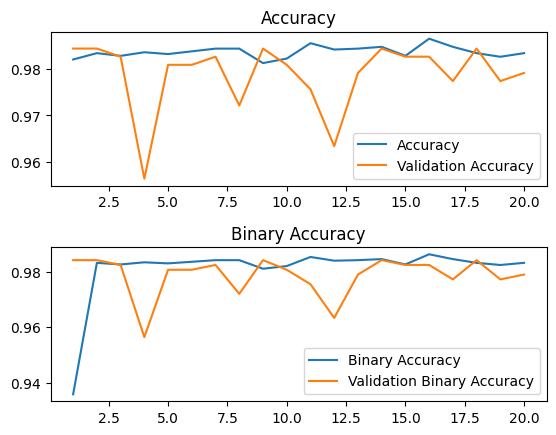

---Test metrics---
20/20 [==============================] - 0s 3ms/step - loss: 76.7710 - accuracy: 0.9937 - binary_accuracy: 0.9937
---Unique outputs ---
0.0 6352
1.0 19
----------Testing CNNModel1 for INTC----------
---# of ones in Y: 9 | 0.08081170871868547%---
Epoch 1/20
282/282 [==============================] - 4s 7ms/step - loss: 6714.4375 - accuracy: 0.9980 - binary_accuracy: 0.9977 - val_loss: 14721.0117 - val_accuracy: 0.9980 - val_binary_accuracy: 0.9980
Epoch 2/20
282/282 [==============================] - 1s 5ms/step - loss: 1967.3765 - accuracy: 0.9986 - binary_accuracy: 0.9986 - val_loss: 3494.8555 - val_accuracy: 0.9980 - val_binary_accuracy: 0.9980
Epoch 3/20
282/282 [==============================] - 2s 6ms/step - loss: 522.7456 - accuracy: 0.9986 - binary_accuracy: 0.9986 - val_loss: 3437.5120 - val_accuracy: 0.9980 - val_binary_accuracy: 0.9980
Epoch 4/20
282/282 [==============================] - 2s 7ms/step - loss: 504.4560 - accuracy: 0.9983 - binary_accuracy: 0.

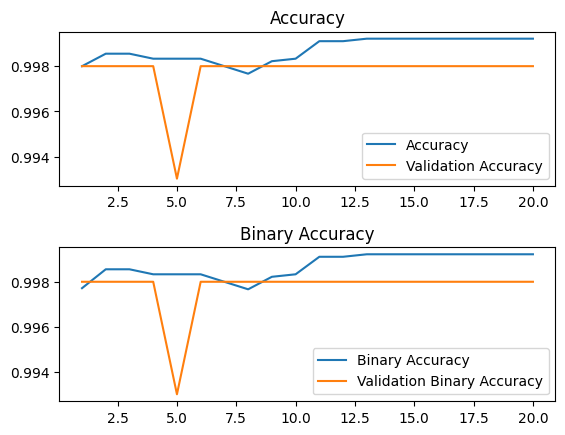

---Test metrics---
35/35 [==============================] - 0s 3ms/step - loss: 1.4734 - accuracy: 0.9991 - binary_accuracy: 0.9991
---Unique outputs ---
0.0 11136
----------Testing CNNModel1 for AMD----------
---# of ones in Y: 790 | 7.09347220975128%---
Epoch 1/20
282/282 [==============================] - 3s 7ms/step - loss: 5431.0459 - accuracy: 0.9210 - binary_accuracy: 0.9295 - val_loss: 1230.2847 - val_accuracy: 0.9252 - val_binary_accuracy: 0.9252
Epoch 2/20
282/282 [==============================] - 1s 5ms/step - loss: 1739.2395 - accuracy: 0.9200 - binary_accuracy: 0.9200 - val_loss: 562.1230 - val_accuracy: 0.9232 - val_binary_accuracy: 0.9232
Epoch 3/20
282/282 [==============================] - 1s 5ms/step - loss: 677.6360 - accuracy: 0.9237 - binary_accuracy: 0.9237 - val_loss: 198.5814 - val_accuracy: 0.9192 - val_binary_accuracy: 0.9192
Epoch 4/20
282/282 [==============================] - 1s 5ms/step - loss: 289.8794 - accuracy: 0.9220 - binary_accuracy: 0.9220 - val_l

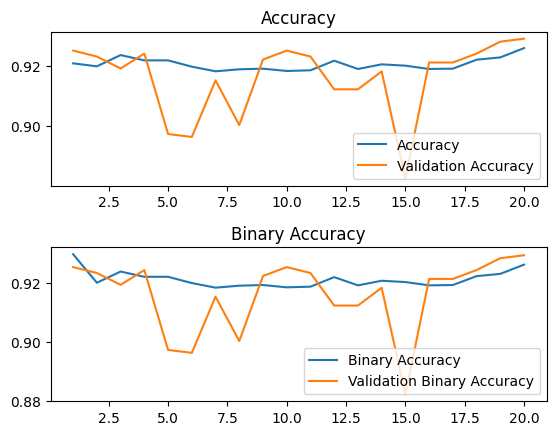

---Test metrics---
35/35 [==============================] - 0s 3ms/step - loss: 3.5244 - accuracy: 0.9345 - binary_accuracy: 0.9345
---Unique outputs ---
0.0 10983
0.1 63
0.2 21
0.3 24
0.4 10
0.5 7
0.6 11
0.7 5
0.8 3
1.0 10
----------Testing CNNModel1 for NVDA----------
---# of ones in Y: 0 | 0.0%---
Epoch 1/20
162/162 [==============================] - 3s 8ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - binary_accuracy: 0.9884 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - val_binary_accuracy: 1.0000
Epoch 2/20
162/162 [==============================] - 1s 7ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - binary_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - val_binary_accuracy: 1.0000
Epoch 3/20
162/162 [==============================] - 1s 6ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - binary_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - val_binary_accuracy: 1.0000
Epoch 4/20
162/162 [==============================] - 1s 5ms/step - loss: 0.0000

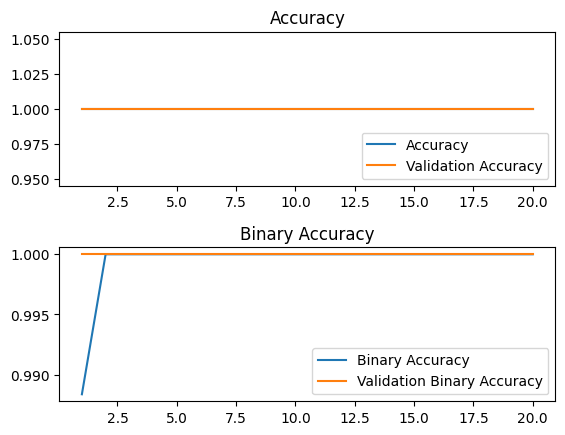

---Test metrics---
20/20 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - binary_accuracy: 1.0000
---Unique outputs ---
0.0 6372
----------Testing CNNModel1 for INTC----------
---# of ones in Y: 0 | 0.0%---
Epoch 1/20
282/282 [==============================] - 3s 6ms/step - loss: 52.3742 - accuracy: 0.9999 - binary_accuracy: 0.9999 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - val_binary_accuracy: 1.0000
Epoch 2/20
282/282 [==============================] - 1s 5ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - binary_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - val_binary_accuracy: 1.0000
Epoch 3/20
282/282 [==============================] - 1s 5ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - binary_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - val_binary_accuracy: 1.0000
Epoch 4/20
282/282 [==============================] - 2s 6ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - binary_accuracy: 1.0000 - val_loss

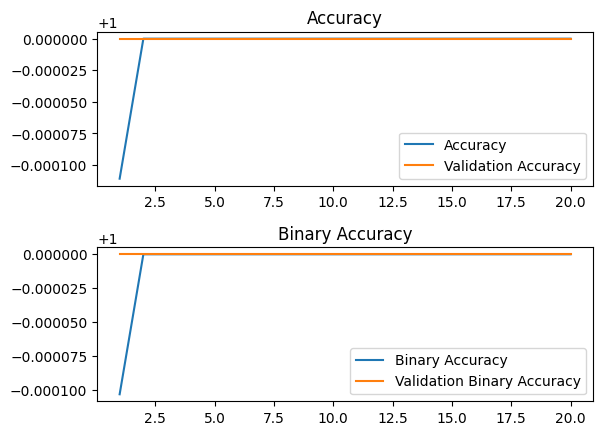

---Test metrics---
35/35 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - binary_accuracy: 1.0000
---Unique outputs ---
0.0 11137
----------Testing CNNModel1 for AMD----------
---# of ones in Y: 719 | 6.455957618748316%---
Epoch 1/20
282/282 [==============================] - 4s 8ms/step - loss: 2977.6125 - accuracy: 0.9334 - binary_accuracy: 0.9407 - val_loss: 1102.6006 - val_accuracy: 0.9222 - val_binary_accuracy: 0.9222
Epoch 2/20
282/282 [==============================] - 1s 5ms/step - loss: 658.0312 - accuracy: 0.9317 - binary_accuracy: 0.9317 - val_loss: 323.6477 - val_accuracy: 0.9242 - val_binary_accuracy: 0.9242
Epoch 3/20
282/282 [==============================] - 1s 5ms/step - loss: 411.5041 - accuracy: 0.9337 - binary_accuracy: 0.9337 - val_loss: 234.4026 - val_accuracy: 0.9242 - val_binary_accuracy: 0.9242
Epoch 4/20
282/282 [==============================] - 1s 5ms/step - loss: 204.0099 - accuracy: 0.9334 - binary_accuracy: 0.9334 - v

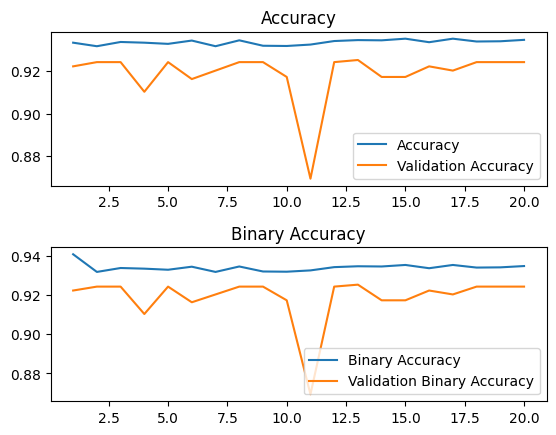

---Test metrics---
35/35 [==============================] - 0s 3ms/step - loss: 10.1377 - accuracy: 0.9417 - binary_accuracy: 0.9417
---Unique outputs ---
0.0 11137


In [ ]:
# Test different percentages
percents = [0.01, 0.10, 0.50]
for percent in percents:
  INCREASE_PERCENT = percent
  test_model(CNNModel1, ['NVDA', 'INTC', 'AMD'])

----------Testing CNNModel1 for NVDA----------
---# of ones in Y: 1268 | 19.899560577526678%---
Epoch 1/20
5161/5161 ━━━━━━━━━━━━━━━━━━━━ 5s 780us/step - accuracy: 0.7443 - binary_accuracy: 0.7295 - loss: 978236.7500 - val_accuracy: 0.7822 - val_binary_accuracy: 0.7822 - val_loss: 0.5252
Epoch 2/20
5161/5161 ━━━━━━━━━━━━━━━━━━━━ 4s 790us/step - accuracy: 0.8029 - binary_accuracy: 0.8029 - loss: 166.2753 - val_accuracy: 0.7822 - val_binary_accuracy: 0.7822 - val_loss: 0.5248
Epoch 3/20
5161/5161 ━━━━━━━━━━━━━━━━━━━━ 4s 794us/step - accuracy: 0.7955 - binary_accuracy: 0.7955 - loss: 0.5069 - val_accuracy: 0.7822 - val_binary_accuracy: 0.7822 - val_loss: 0.5262
Epoch 4/20
5161/5161 ━━━━━━━━━━━━━━━━━━━━ 4s 786us/step - accuracy: 0.8104 - binary_accuracy: 0.8104 - loss: 0.4832 - val_accuracy: 0.7822 - val_binary_accuracy: 0.7822 - val_loss: 0.5229
Epoch 5/20
5161/5161 ━━━━━━━━━━━━━━━━━━━━ 4s 765us/step - accuracy: 0.7997 - binary_accuracy: 0.7997 - loss: 0.4966 - val_accuracy: 0.7822 - val_

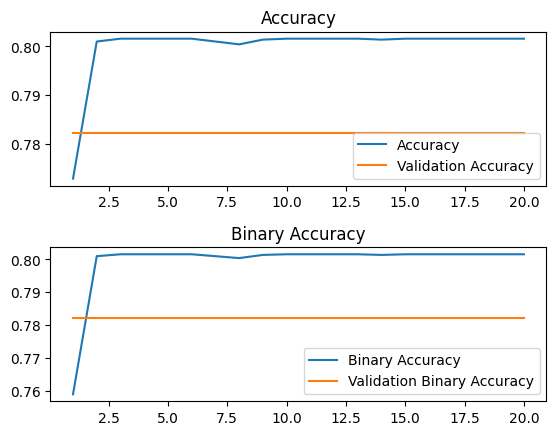

---Test metrics---
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8213 - binary_accuracy: 0.8213 - loss: 0.4791
---Unique outputs ---
0.1 4395
0.2 569
0.3 1408
----------Testing CNNModel1 for INTC----------
---# of ones in Y: 1447 | 12.992726946215319%---
Epoch 1/20
9020/9020 ━━━━━━━━━━━━━━━━━━━━ 8s 781us/step - accuracy: 0.8375 - binary_accuracy: 0.8352 - loss: 27736.0215 - val_accuracy: 0.8784 - val_binary_accuracy: 0.8784 - val_loss: 0.3691
Epoch 2/20
9020/9020 ━━━━━━━━━━━━━━━━━━━━ 7s 789us/step - accuracy: 0.8633 - binary_accuracy: 0.8633 - loss: 0.3970 - val_accuracy: 0.8784 - val_binary_accuracy: 0.8784 - val_loss: 0.3689
Epoch 3/20
9020/9020 ━━━━━━━━━━━━━━━━━━━━ 7s 789us/step - accuracy: 0.8701 - binary_accuracy: 0.8701 - loss: 0.3837 - val_accuracy: 0.8784 - val_binary_accuracy: 0.8784 - val_loss: 0.3683
Epoch 4/20
9020/9020 ━━━━━━━━━━━━━━━━━━━━ 7s 786us/step - accuracy: 0.8722 - binary_accuracy: 0.8722 - loss: 1284.0591 - val_accuracy: 0.8784 - val_binary_accuracy: 0.878

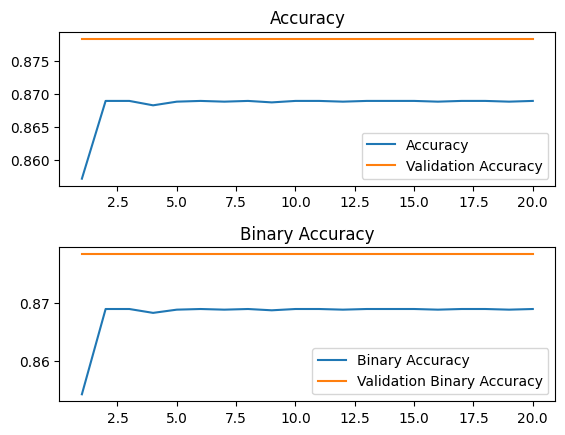

---Test metrics---
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8786 - binary_accuracy: 0.8786 - loss: 0.3631
---Unique outputs ---
0.0 156
0.1 8054
0.2 2927
----------Testing CNNModel1 for AMD----------
---# of ones in Y: 2870 | 25.769956002514142%---
Epoch 1/20
9020/9020 ━━━━━━━━━━━━━━━━━━━━ 7s 674us/step - accuracy: 0.6984 - binary_accuracy: 0.7528 - loss: 44088.3438 - val_accuracy: 0.7478 - val_binary_accuracy: 0.7478 - val_loss: 0.5368
Epoch 2/20
9020/9020 ━━━━━━━━━━━━━━━━━━━━ 6s 718us/step - accuracy: 0.7439 - binary_accuracy: 0.7439 - loss: 0.5685 - val_accuracy: 0.8096 - val_binary_accuracy: 0.8096 - val_loss: 0.5309
Epoch 3/20
9020/9020 ━━━━━━━━━━━━━━━━━━━━ 7s 734us/step - accuracy: 0.8010 - binary_accuracy: 0.8010 - loss: 1.4273 - val_accuracy: 0.8086 - val_binary_accuracy: 0.8086 - val_loss: 24.5610
Epoch 4/20
9020/9020 ━━━━━━━━━━━━━━━━━━━━ 6s 698us/step - accuracy: 0.8053 - binary_accuracy: 0.8053 - loss: 0.7837 - val_accuracy: 0.8086 - val_binary_accuracy: 0.8086 -

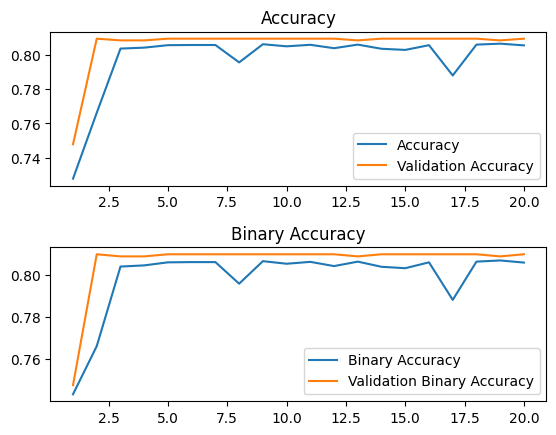

---Test metrics---
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8223 - binary_accuracy: 0.8223 - loss: 0.4591
---Unique outputs ---
0.0 12
0.1 13
0.2 10059
0.3 322
0.4 3
0.7 3
1.0 725
----------Testing CNNModel1 for NVDA----------
---# of ones in Y: 1268 | 19.899560577526678%---
Epoch 1/20
2581/2581 ━━━━━━━━━━━━━━━━━━━━ 3s 856us/step - accuracy: 0.6940 - binary_accuracy: 0.7397 - loss: 1485869.1250 - val_accuracy: 0.8136 - val_binary_accuracy: 0.8136 - val_loss: 18.3569
Epoch 2/20
2581/2581 ━━━━━━━━━━━━━━━━━━━━ 2s 709us/step - accuracy: 0.7877 - binary_accuracy: 0.7877 - loss: 19.0179 - val_accuracy: 0.8136 - val_binary_accuracy: 0.8136 - val_loss: 0.4805
Epoch 3/20
2581/2581 ━━━━━━━━━━━━━━━━━━━━ 2s 721us/step - accuracy: 0.8013 - binary_accuracy: 0.8013 - loss: 0.4978 - val_accuracy: 0.8136 - val_binary_accuracy: 0.8136 - val_loss: 0.4802
Epoch 4/20
2581/2581 ━━━━━━━━━━━━━━━━━━━━ 2s 792us/step - accuracy: 0.8033 - binary_accuracy: 0.8033 - loss: 0.4940 - val_accuracy: 0.8136 -

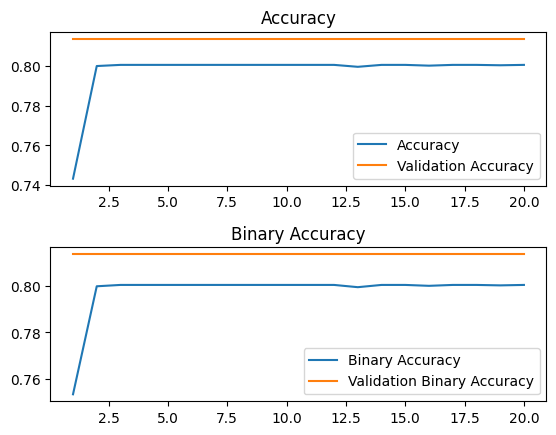

---Test metrics---
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7718 - binary_accuracy: 0.7718 - loss: 0.5260
---Unique outputs ---
0.2 4691
0.3 1681
----------Testing CNNModel1 for INTC----------
---# of ones in Y: 1447 | 12.992726946215319%---
Epoch 1/20
4510/4510 ━━━━━━━━━━━━━━━━━━━━ 5s 827us/step - accuracy: 0.7589 - binary_accuracy: 0.7650 - loss: 75289.8906 - val_accuracy: 0.8694 - val_binary_accuracy: 0.8694 - val_loss: 416.7843
Epoch 2/20
4510/4510 ━━━━━━━━━━━━━━━━━━━━ 3s 770us/step - accuracy: 0.7680 - binary_accuracy: 0.7680 - loss: 279.2128 - val_accuracy: 0.5643 - val_binary_accuracy: 0.5643 - val_loss: 30.2385
Epoch 3/20
4510/4510 ━━━━━━━━━━━━━━━━━━━━ 3s 731us/step - accuracy: 0.7582 - binary_accuracy: 0.7582 - loss: 20.6528 - val_accuracy: 0.8774 - val_binary_accuracy: 0.8774 - val_loss: 0.3983
Epoch 4/20
4510/4510 ━━━━━━━━━━━━━━━━━━━━ 3s 728us/step - accuracy: 0.8710 - binary_accuracy: 0.8710 - loss: 0.3916 - val_accuracy: 0.8774 - val_binary_accuracy: 0.8774 - v

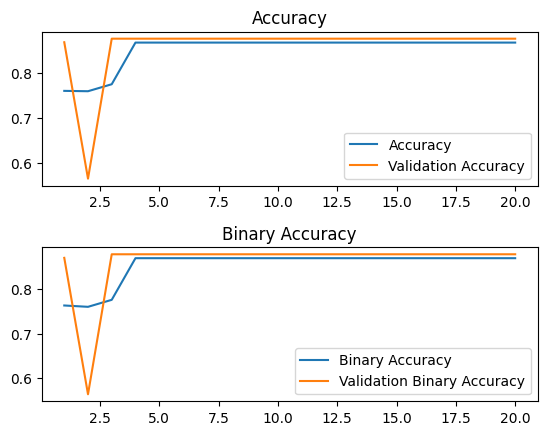

---Test metrics---
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8734 - binary_accuracy: 0.8734 - loss: 0.3799
---Unique outputs ---
0.0 6
0.1 11131
----------Testing CNNModel1 for AMD----------
---# of ones in Y: 2870 | 25.769956002514142%---
Epoch 1/20
4510/4510 ━━━━━━━━━━━━━━━━━━━━ 4s 750us/step - accuracy: 0.6410 - binary_accuracy: 0.7096 - loss: 68871.8438 - val_accuracy: 0.7368 - val_binary_accuracy: 0.7368 - val_loss: 95.4719
Epoch 2/20
4510/4510 ━━━━━━━━━━━━━━━━━━━━ 3s 703us/step - accuracy: 0.7413 - binary_accuracy: 0.7413 - loss: 11.2529 - val_accuracy: 0.7478 - val_binary_accuracy: 0.7478 - val_loss: 0.5652
Epoch 3/20
4510/4510 ━━━━━━━━━━━━━━━━━━━━ 3s 707us/step - accuracy: 0.7369 - binary_accuracy: 0.7369 - loss: 16.8057 - val_accuracy: 0.7478 - val_binary_accuracy: 0.7478 - val_loss: 0.5648
Epoch 4/20
4510/4510 ━━━━━━━━━━━━━━━━━━━━ 3s 696us/step - accuracy: 0.7481 - binary_accuracy: 0.7481 - loss: 0.5649 - val_accuracy: 0.7478 - val_binary_accuracy: 0.7478 - val_los

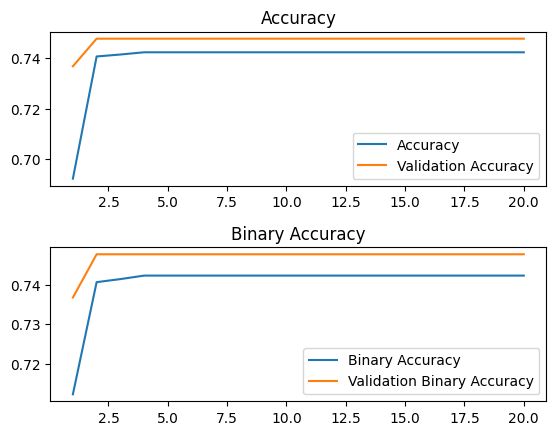

---Test metrics---
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7269 - binary_accuracy: 0.7269 - loss: 0.5869
---Unique outputs ---
0.3 11137
----------Testing CNNModel1 for NVDA----------
---# of ones in Y: 1268 | 19.899560577526678%---
Epoch 1/20
1291/1291 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.7081 - binary_accuracy: 0.7271 - loss: 1155416.5000 - val_accuracy: 0.8031 - val_binary_accuracy: 0.8031 - val_loss: 9.2696
Epoch 2/20
1291/1291 ━━━━━━━━━━━━━━━━━━━━ 1s 733us/step - accuracy: 0.8105 - binary_accuracy: 0.8105 - loss: 204.9473 - val_accuracy: 0.8031 - val_binary_accuracy: 0.8031 - val_loss: 0.4979
Epoch 3/20
1291/1291 ━━━━━━━━━━━━━━━━━━━━ 1s 737us/step - accuracy: 0.8143 - binary_accuracy: 0.8143 - loss: 0.4804 - val_accuracy: 0.8031 - val_binary_accuracy: 0.8031 - val_loss: 0.4938
Epoch 4/20
1291/1291 ━━━━━━━━━━━━━━━━━━━━ 1s 721us/step - accuracy: 0.8011 - binary_accuracy: 0.8011 - loss: 0.4958 - val_accuracy: 0.8031 - val_binary_accuracy: 0.8031 - val_loss: 0.4

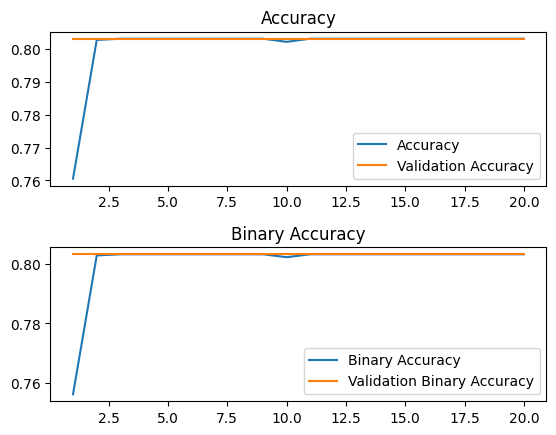

---Test metrics---
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7877 - binary_accuracy: 0.7877 - loss: 0.5097
---Unique outputs ---
0.1 1351
0.2 3931
0.3 1089
----------Testing CNNModel1 for INTC----------
---# of ones in Y: 1447 | 12.992726946215319%---
Epoch 1/20
2255/2255 ━━━━━━━━━━━━━━━━━━━━ 3s 874us/step - accuracy: 0.7552 - binary_accuracy: 0.7628 - loss: 137906.2344 - val_accuracy: 0.8754 - val_binary_accuracy: 0.8754 - val_loss: 3264.2476
Epoch 2/20
2255/2255 ━━━━━━━━━━━━━━━━━━━━ 2s 702us/step - accuracy: 0.7666 - binary_accuracy: 0.7666 - loss: 1378.1727 - val_accuracy: 0.8694 - val_binary_accuracy: 0.8694 - val_loss: 169.1127
Epoch 3/20
2255/2255 ━━━━━━━━━━━━━━━━━━━━ 2s 720us/step - accuracy: 0.7967 - binary_accuracy: 0.7967 - loss: 152.8376 - val_accuracy: 0.8764 - val_binary_accuracy: 0.8764 - val_loss: 0.3741
Epoch 4/20
2255/2255 ━━━━━━━━━━━━━━━━━━━━ 2s 717us/step - accuracy: 0.8729 - binary_accuracy: 0.8729 - loss: 0.3810 - val_accuracy: 0.8764 - val_binary_accura

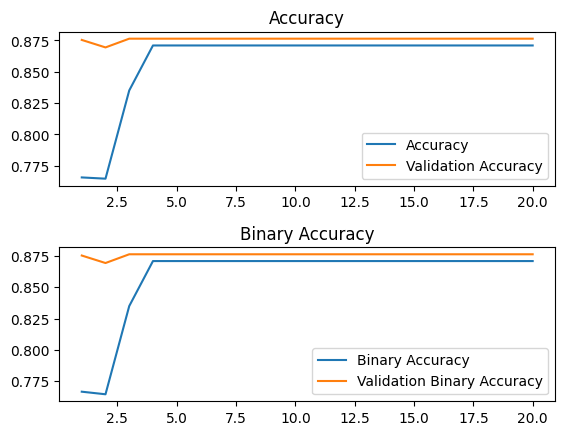

---Test metrics---
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8567 - binary_accuracy: 0.8567 - loss: 0.4110
---Unique outputs ---
0.1 11137
----------Testing CNNModel1 for AMD----------
---# of ones in Y: 2870 | 25.769956002514142%---
Epoch 1/20
2255/2255 ━━━━━━━━━━━━━━━━━━━━ 3s 778us/step - accuracy: 0.6674 - binary_accuracy: 0.7258 - loss: 85724.3750 - val_accuracy: 0.7458 - val_binary_accuracy: 0.7458 - val_loss: 47.3798
Epoch 2/20
2255/2255 ━━━━━━━━━━━━━━━━━━━━ 2s 696us/step - accuracy: 0.7583 - binary_accuracy: 0.7583 - loss: 13.9711 - val_accuracy: 0.8086 - val_binary_accuracy: 0.8086 - val_loss: 18.9069
Epoch 3/20
2255/2255 ━━━━━━━━━━━━━━━━━━━━ 2s 699us/step - accuracy: 0.8066 - binary_accuracy: 0.8066 - loss: 19.9242 - val_accuracy: 0.8076 - val_binary_accuracy: 0.8076 - val_loss: 4.0657
Epoch 4/20
2255/2255 ━━━━━━━━━━━━━━━━━━━━ 2s 714us/step - accuracy: 0.8081 - binary_accuracy: 0.8081 - loss: 0.5423 - val_accuracy: 0.8086 - val_binary_accuracy: 0.8086 - val_loss: 1.

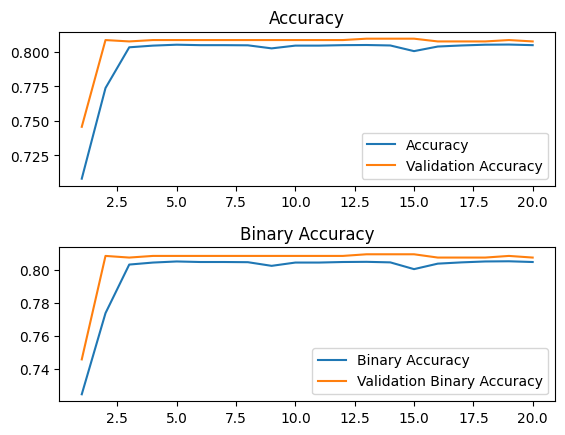

---Test metrics---
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8213 - binary_accuracy: 0.8213 - loss: 0.4607
---Unique outputs ---
0.1 6
0.2 9812
0.3 610
0.4 2
0.5 2
0.6 2
0.7 2
0.8 4
0.9 11
1.0 686


In [13]:
# Test different batch sizes
batches = [1, 2, 4]
for batch in batches:
  BATCH_SIZE = batch
  test_model(CNNModel1, ['NVDA', 'INTC', 'AMD'])